# Electric Vehicle Population Data

In [1]:
# pip install beautifulsoup4

In [2]:
# pip install pandas geopandas matplotlib

In [3]:
# pip install geoplot

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from scipy.stats import chi2_contingency
import geopandas as gpd

warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("H:\My Drive\DAE\CVA\Project 1\Electric_Vehicle_Population_Data_1.csv")
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,3C3CFFGE4E,Yakima,Yakima,WA,98902.0,2014,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,87,0,14.0,1593721,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10
1,5YJXCBE40H,Thurston,Olympia,WA,98513.0,2017,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,200,0,2.0,257167501,POINT (-122.817545 46.98876),PUGET SOUND ENERGY INC,5.306701e+10
2,3MW39FS03P,King,Renton,WA,98058.0,2023,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,20,0,11.0,224071816,POINT (-122.1298876 47.4451257),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,7PDSGABA8P,Snohomish,Bothell,WA,98012.0,2023,RIVIAN,R1S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,21.0,260084653,POINT (-122.1873 47.820245),PUGET SOUND ENERGY INC,5.306105e+10
4,5YJ3E1EB8L,King,Kent,WA,98031.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,33.0,253771913,POINT (-122.2012521 47.3931814),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10


## Cleaning Dataset

In [6]:
df.isnull().sum()

VIN (1-10)                                             0
County                                                 5
City                                                   5
State                                                  0
Postal Code                                            5
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 360
DOL Vehicle ID                                         0
Vehicle Location                                      10
Electric Utility                                       5
2020 Census Tract                                      5
dtype: int64

In [7]:
# Dropping Duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Dropping all the null values
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

#### Working on null values in the Electric range column

In [10]:
df['Details'] = (

    df['Make'].str.replace(' ', '_') + '-' +
    df['Model'].str.replace(' ', '_') + '-' +
    df['Model Year'].astype(str)
)

df['Make_Model'] = (

    df['Make'].str.replace(' ', '_') + '-' +
    df['Model'].str.replace(' ', '_')
)

# print(df[['Model Year', 'Make', 'Model', 'Electric Range', 'Make_Model']])


In [11]:
rows_to_replace = df[df['Electric Range'] == 0].merge(df[df['Electric Range'] != 0], on='Details')
print("Rows to replace:")

print(rows_to_replace[['Model Year_x', 'Make_x', 'Model_x', 'Electric Range_x', 'Details']])

df.loc[df['Electric Range'] == 0, 'Electric Range'] = rows_to_replace['Electric Range_y']

print("\nDataFrame after replacement:")
# df[['Model Year', 'Make', 'Model', 'Electric Range', 'Make_Model']]


Rows to replace:
        Model Year_x   Make_x Model_x  Electric Range_x             Details
0               2023      KIA    NIRO                 0       KIA-NIRO-2023
1               2023      KIA    NIRO                 0       KIA-NIRO-2023
2               2023      KIA    NIRO                 0       KIA-NIRO-2023
3               2023      KIA    NIRO                 0       KIA-NIRO-2023
4               2023      KIA    NIRO                 0       KIA-NIRO-2023
...              ...      ...     ...               ...                 ...
301984          2021  HYUNDAI   IONIQ                 0  HYUNDAI-IONIQ-2021
301985          2021  HYUNDAI   IONIQ                 0  HYUNDAI-IONIQ-2021
301986          2021  HYUNDAI   IONIQ                 0  HYUNDAI-IONIQ-2021
301987          2021  HYUNDAI   IONIQ                 0  HYUNDAI-IONIQ-2021
301988          2021  HYUNDAI   IONIQ                 0  HYUNDAI-IONIQ-2021

[301989 rows x 5 columns]

DataFrame after replacement:


In [12]:
# df.head(5)

## Preprocessing

### Mapping the Clean Alternative Fuel Vehicle (CAFV) Eligibility
- Clean Alternative Fuel Vehicle Eligible : 'Eligible',
- Not eligible due to low battery range : 'Not eligible',
- Eligibility unknown as battery range has not been researched : 'Eligibility unknown'

In [13]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()

array(['Clean Alternative Fuel Vehicle Eligible',
       'Not eligible due to low battery range',
       'Eligibility unknown as battery range has not been researched'],
      dtype=object)

In [14]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].map({
    'Clean Alternative Fuel Vehicle Eligible': 'Eligible',
    'Not eligible due to low battery range': 'Not eligible',
    'Eligibility unknown as battery range has not been researched': 'Eligibility unknown'
})

In [15]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()

array(['Eligible', 'Not eligible', 'Eligibility unknown'], dtype=object)

### Mapping the Electric Vehicle Type
- Battery Electric Vehicle (BEV): 'Battery_EV',
- Plug-in Hybrid Electric Vehicle (PHEV): 'Plug-in Hybrid_EV'

In [16]:
df['Electric Vehicle Type'].unique()

array(['Battery Electric Vehicle (BEV)',
       'Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [17]:
df['Electric Vehicle Type'] = df['Electric Vehicle Type'].map({
    'Battery Electric Vehicle (BEV)': 'Battery_EV',
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'Plug-in Hybrid_EV'
})

In [18]:
df['Electric Vehicle Type'].unique()

array(['Battery_EV', 'Plug-in Hybrid_EV'], dtype=object)

In [19]:
df.head(5)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Details,Make_Model
0,3C3CFFGE4E,Yakima,Yakima,WA,98902.0,2014,FIAT,500,Battery_EV,Eligible,87,0,14.0,1593721,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10,FIAT-500-2014,FIAT-500
1,5YJXCBE40H,Thurston,Olympia,WA,98513.0,2017,TESLA,MODEL X,Battery_EV,Eligible,200,0,2.0,257167501,POINT (-122.817545 46.98876),PUGET SOUND ENERGY INC,5.306701e+10,TESLA-MODEL_X-2017,TESLA-MODEL_X
2,3MW39FS03P,King,Renton,WA,98058.0,2023,BMW,330E,Plug-in Hybrid_EV,Not eligible,20,0,11.0,224071816,POINT (-122.1298876 47.4451257),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,BMW-330E-2023,BMW-330E
3,7PDSGABA8P,Snohomish,Bothell,WA,98012.0,2023,RIVIAN,R1S,Battery_EV,Eligibility unknown,33,0,21.0,260084653,POINT (-122.1873 47.820245),PUGET SOUND ENERGY INC,5.306105e+10,RIVIAN-R1S-2023,RIVIAN-R1S
4,5YJ3E1EB8L,King,Kent,WA,98031.0,2020,TESLA,MODEL 3,Battery_EV,Eligible,322,0,33.0,253771913,POINT (-122.2012521 47.3931814),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,TESLA-MODEL_3-2020,TESLA-MODEL_3


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166435 entries, 0 to 166799
Data columns (total 19 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         166435 non-null  object 
 1   County                                             166435 non-null  object 
 2   City                                               166435 non-null  object 
 3   State                                              166435 non-null  object 
 4   Postal Code                                        166435 non-null  float64
 5   Model Year                                         166435 non-null  int64  
 6   Make                                               166435 non-null  object 
 7   Model                                              166435 non-null  object 
 8   Electric Vehicle Type                              166435 non-null  object 
 9 

#### Creating a new dataframe with data from Washington state only to plot it on the map of Washington

In [21]:
df_wa = df[df['State'] == 'WA']

# Group by 'County' and counting the number of vehicles
df_county_wa = df_wa.groupby('County')['VIN (1-10)'].count().reset_index()

df_county_wa.columns = ['county', 'vehicles']

# df_county_wa

In [22]:
# shapefile of Washington counties
shapefile = gpd.read_file("H:/My Drive/DAE/CVA/Project 1/counties/united_states_washington_administrative_boundaries_level6_counties_polygon.shp")
shp = shapefile.sort_values(by = "name")

# shapefile.columns

In [23]:
shapefile_wa = shapefile

# Retrieving County names
shapefile_wa['name'] = shapefile_wa['name'].str.replace(' County', '')

# merging the DataFrames
merged = shapefile_wa.merge(df_county_wa, left_on='name', right_on='county')



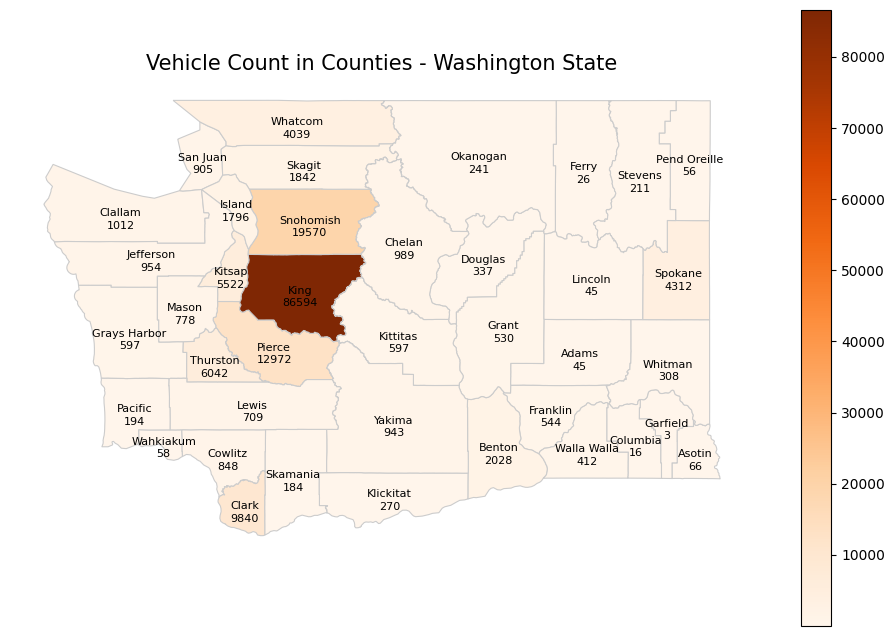

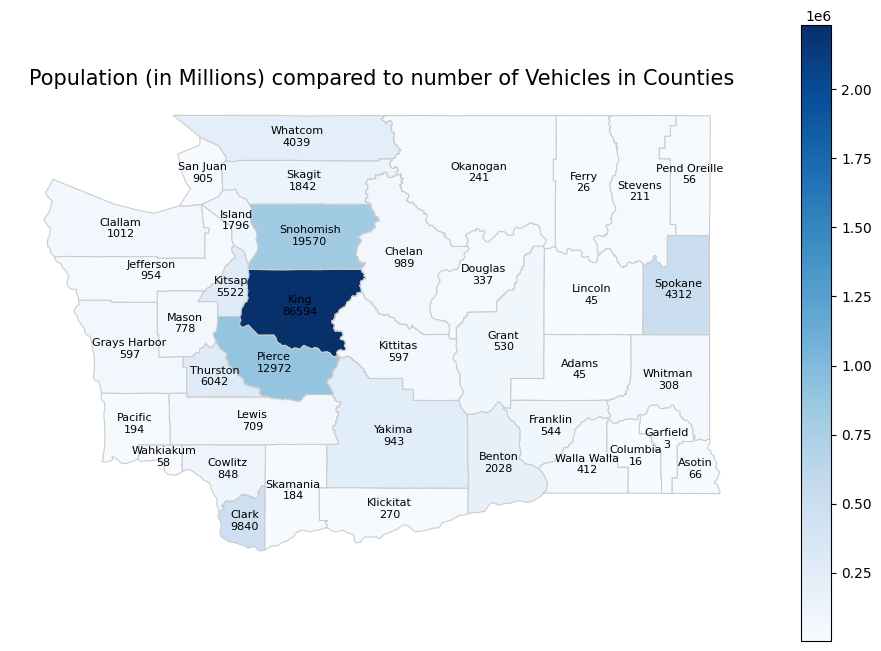

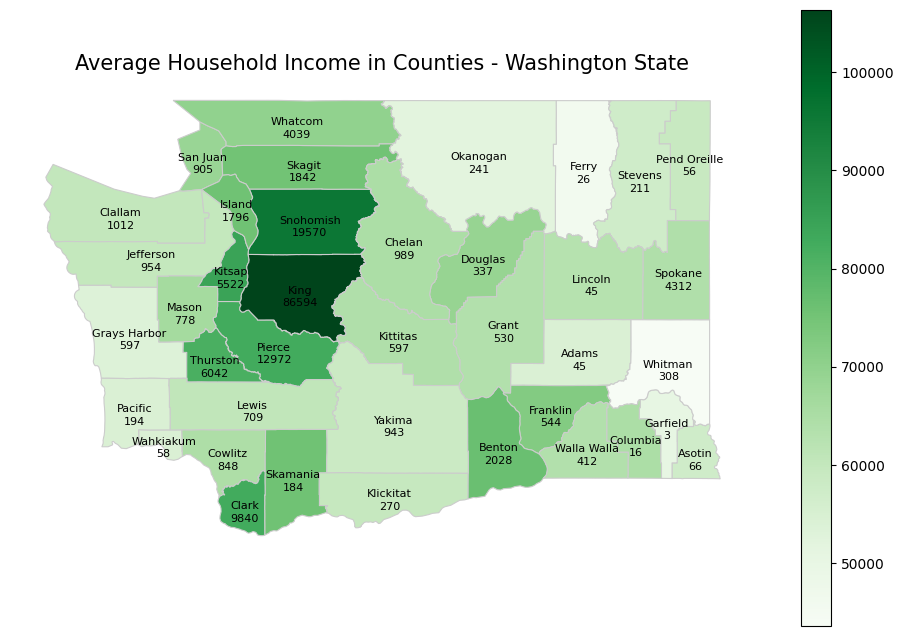

In [24]:
# plotting vehicle counts in the counties
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='vehicles', cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Vehicle Count in Counties - Washington State', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')

for x, y, label, county_name in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['vehicles'], merged['name']):
    ax.text(x, y, f"{county_name}", fontsize=8, ha='center', va='center', color='black')
    ax.text(x, y - 0.1, f"{label}", fontsize=8, ha='center', va='center', color='black')

plt.show()


# plotting population to vehicel counts on county population data
df_population = pd.read_csv("H:/My Drive/DAE/CVA/Project 1/county_population.csv") 
# Merge population data with the existing merged DataFrame
merged_pop = merged.merge(df_population, left_on='name', right_on='County')

# 'Population' column as the color scale
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_pop.plot(column='Population 2018', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)

ax.set_title('Population (in Millions) compared to number of Vehicles in Counties', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')

for x, y, county_name, label in zip(merged_pop.geometry.centroid.x, merged_pop.geometry.centroid.y, merged_pop['name'], merged['vehicles']):
    ax.text(x, y, f"{county_name}\n{label}", fontsize=8, ha='center', va='center', color='Black')

plt.show()

# plotting average household income to number of vehicles in the counties

income_data = pd.read_csv("H:/My Drive/DAE/CVA/Project 1/county_income.csv")

filtered_data = income_data[['Year', 'Household Income by Race', 'Geography']]

filtered_data['County'] = filtered_data['Geography'].apply(lambda x: x.split(' County,')[0])

merged_plot = merged.merge(filtered_data, left_on='name', right_on='County')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_plot.plot(column='Household Income by Race', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Average Household Income in Counties - Washington State', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')

for x, y, income, county_name, vehicles in zip(merged_plot.geometry.centroid.x, merged_plot.geometry.centroid.y, merged_plot['Household Income by Race'], merged_plot['name'], merged_plot['vehicles']):
    ax.text(x, y, f"{county_name}", fontsize=8, ha='center', va='center', color='black')
    ax.text(x, y - 0.1, f"{vehicles}", fontsize=8, ha='center', va='center', color='black')

plt.show()


In [25]:
# income_data.head(5)

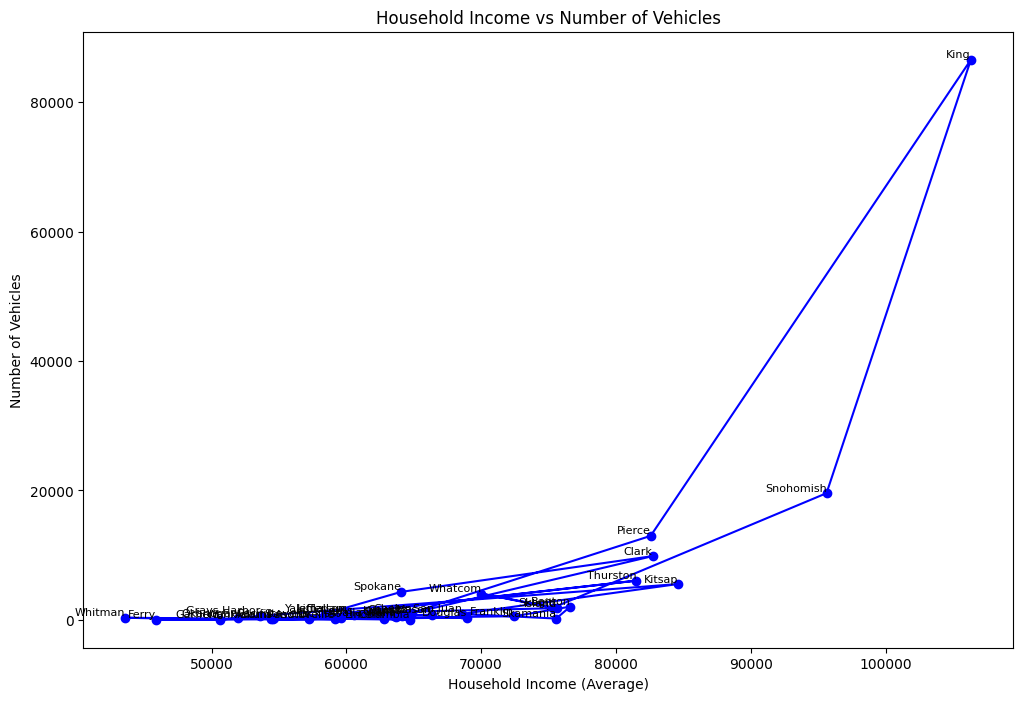

In [26]:
plt.figure(figsize=(12, 8))

# Plotting line plot for Household Income against the count of vehicles
plt.plot(merged_plot['Household Income by Race'], merged_plot['vehicles'], marker='o', linestyle='-', color='blue')

plt.xlabel('Household Income (Average)')
plt.ylabel('Number of Vehicles')
plt.title('Household Income vs Number of Vehicles')

for x, y, county_name in zip(merged_plot['Household Income by Race'], merged_plot['vehicles'], merged_plot['name']):
    plt.text(x, y, county_name, fontsize=8, ha='right', va='bottom', color='black')

plt.show()

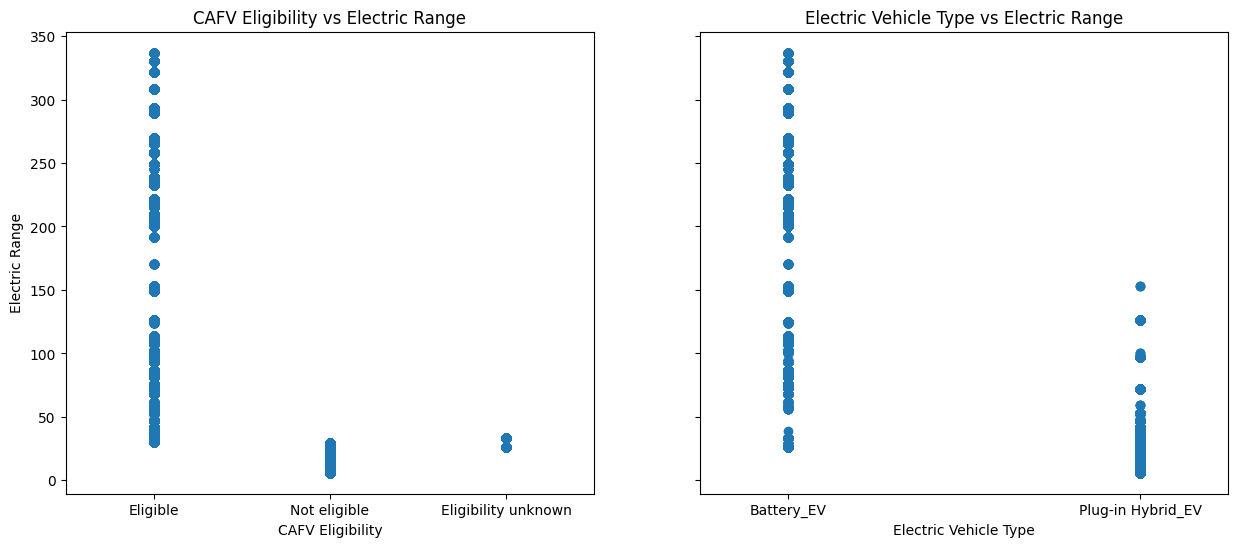

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Scatter plot for CAFV Eligibility and Electric Range
scatter1 = ax1.scatter(df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], df['Electric Range'], cmap='viridis')
ax1.set_xlabel('CAFV Eligibility')
ax1.set_ylabel('Electric Range')
ax1.set_xticks(sorted(df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()))
ax1.set_title('CAFV Eligibility vs Electric Range')


ax1.margins(x=0.25)

# Scatter plot for Electric Vehicle Type and Electric Range
scatter2 = ax2.scatter(df['Electric Vehicle Type'], df['Electric Range'], cmap='viridis')
ax2.set_xlabel('Electric Vehicle Type')
ax2.set_xticks(sorted(df['Electric Vehicle Type'].unique()))
ax2.set_title('Electric Vehicle Type vs Electric Range')

ax2.margins(x=0.25)

plt.show()


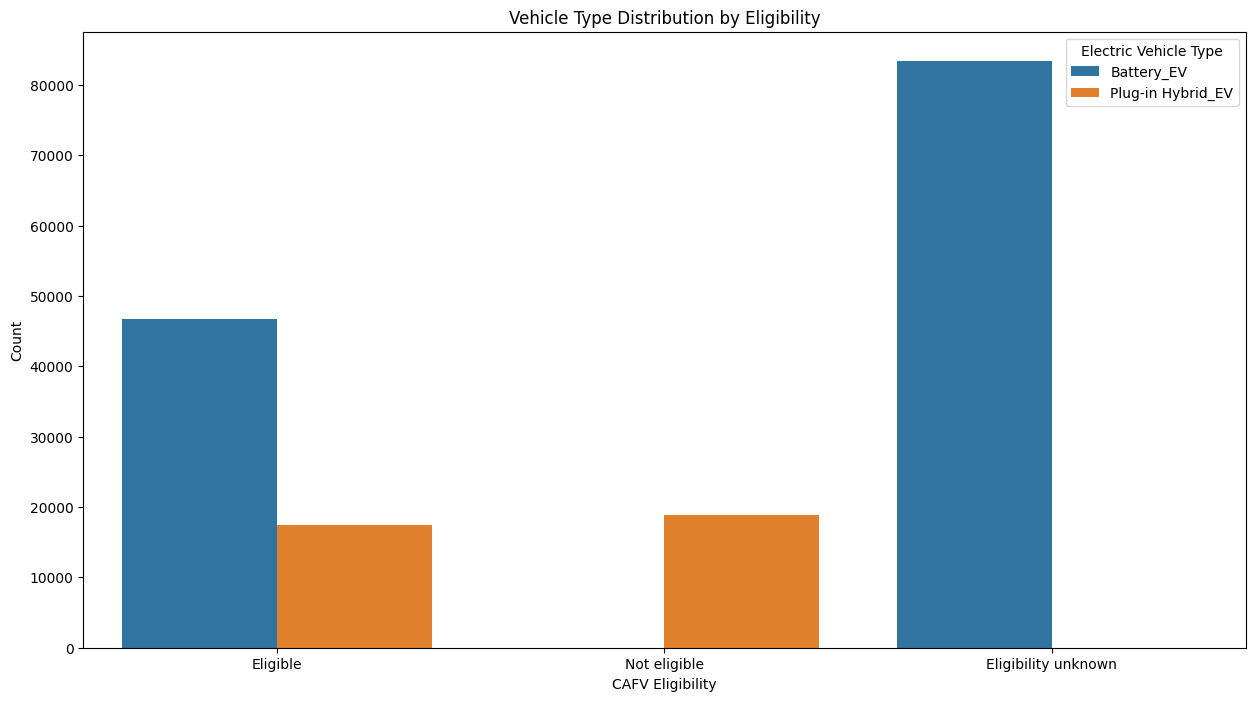

In [28]:
plt.figure(figsize=(15, 8))
sns.countplot(x='Clean Alternative Fuel Vehicle (CAFV) Eligibility', hue='Electric Vehicle Type', data=df)
plt.title('Vehicle Type Distribution by Eligibility')
plt.xlabel('CAFV Eligibility')
plt.ylabel('Count')
plt.legend(title='Electric Vehicle Type', loc='upper right')
plt.show()

### Electric Range of the Vehicles over the years

In [29]:
# Model Years 1997 to 2003
df_1997_2003 = df[(df['Model Year'] >= 1997) & (df['Model Year'] <= 2003)]
idx_1997_2003 = df_1997_2003.groupby('Model Year')['Electric Range'].idxmax()
rows_highest_range_1997_2003 = df_1997_2003.loc[idx_1997_2003]

# Model Years 2008 to 2024
df_2008_2024 = df[(df['Model Year'] >= 2008) & (df['Model Year'] <= 2024)]
idx_2008_2024 = df_2008_2024.groupby('Model Year')['Electric Range'].idxmax()
rows_highest_range_2008_2024 = df_2008_2024.loc[idx_2008_2024]

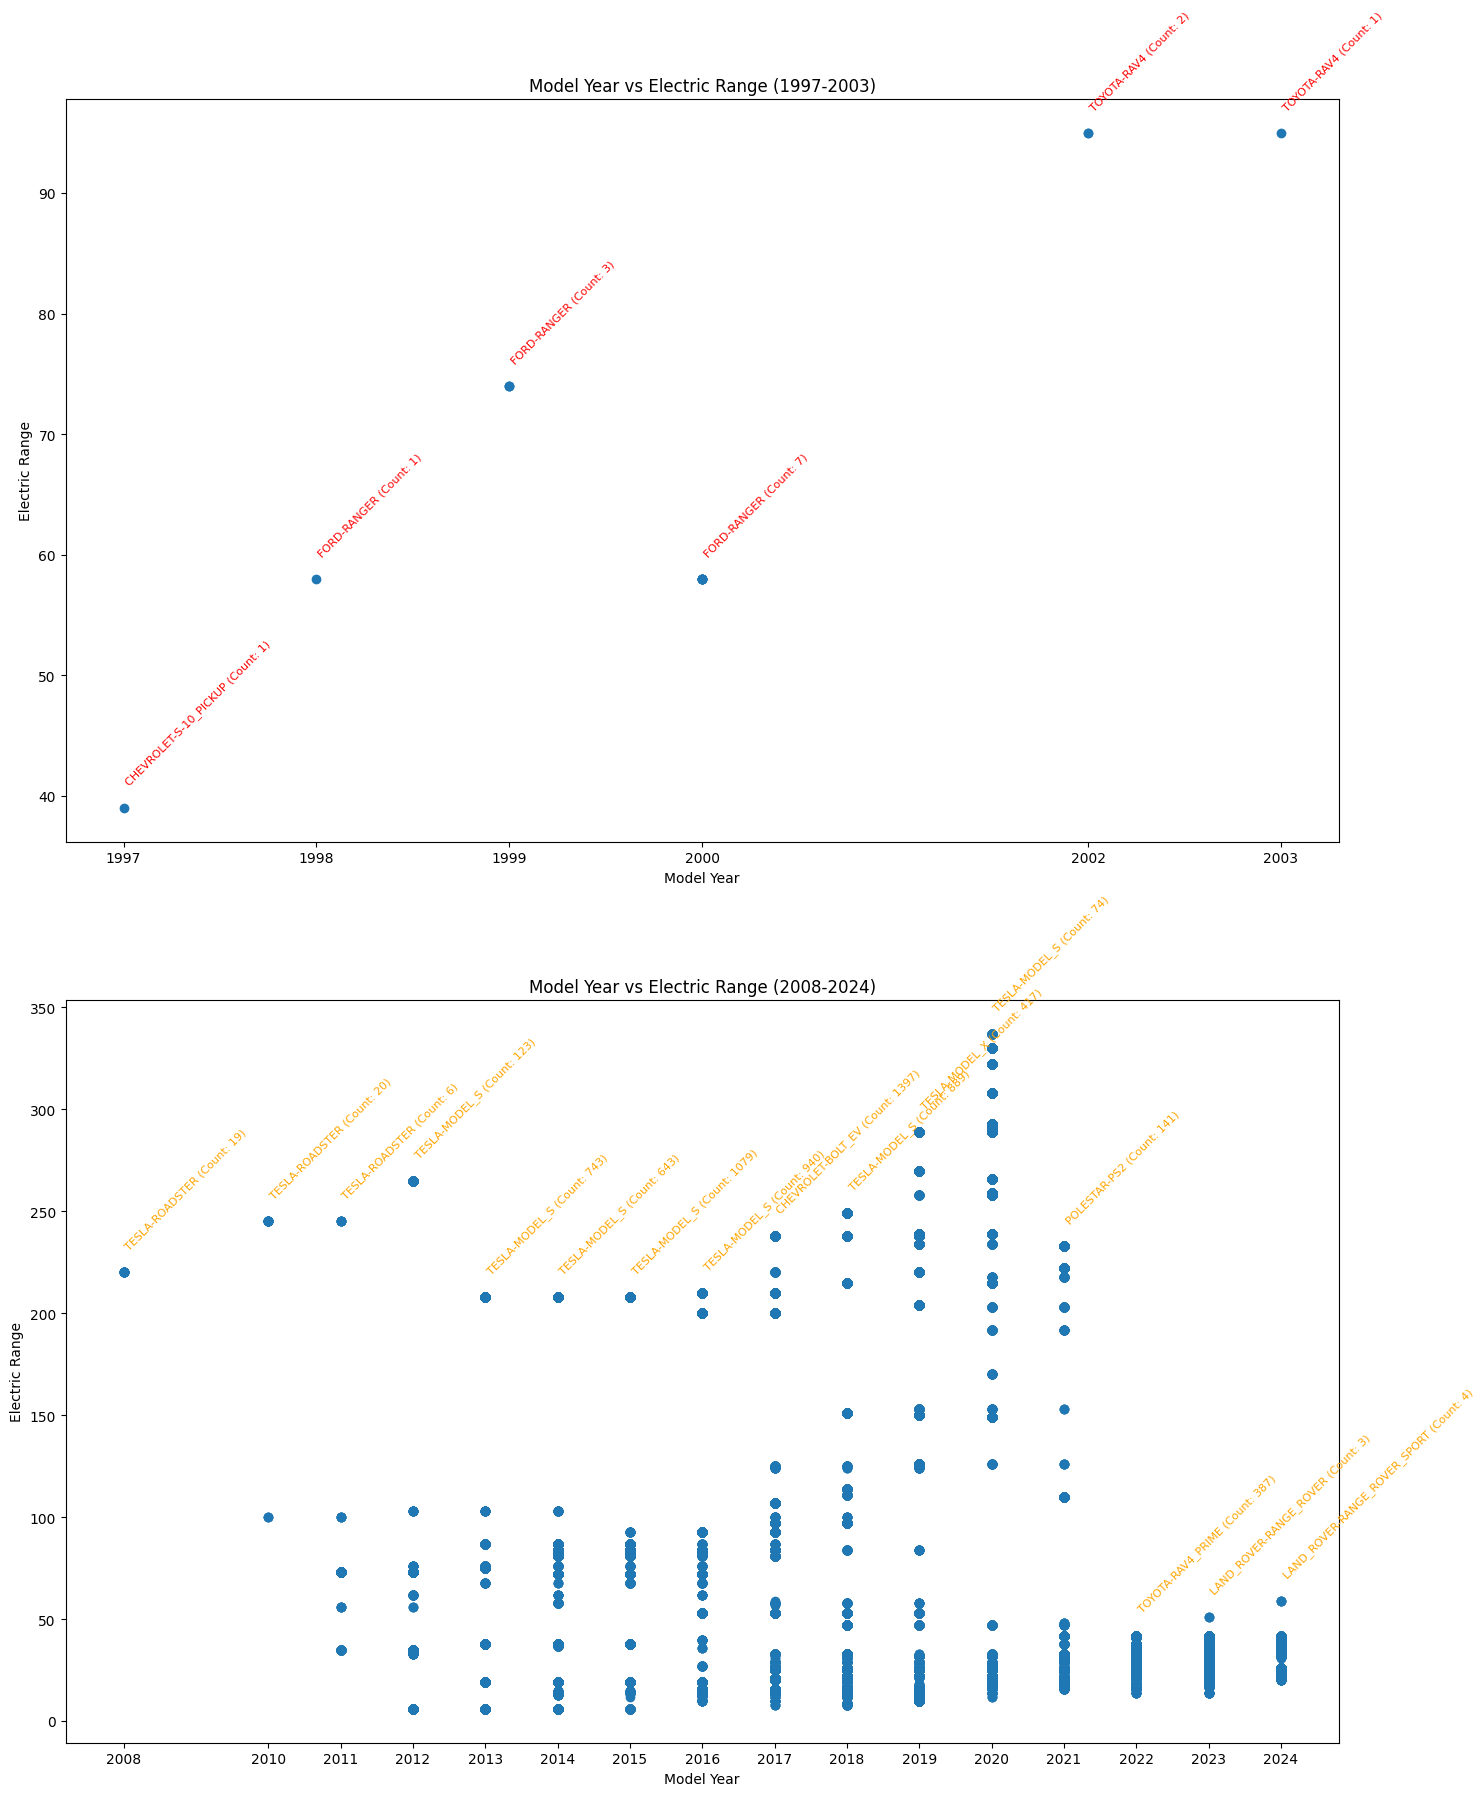

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 18))

# Plot for Model Years 1997 to 2003
ax1.scatter(df_1997_2003['Model Year'], df_1997_2003['Electric Range'])
ax1.set_xlabel('Model Year')
ax1.set_ylabel('Electric Range')
ax1.set_title('Model Year vs Electric Range (1997-2003)')

for _, row in rows_highest_range_1997_2003.iterrows():
    count = df_1997_2003[(df_1997_2003['Model Year'] == row['Model Year']) & (df_1997_2003['Electric Range'] == row['Electric Range'])].shape[0]
    annotation_text = f"{row['Make_Model']} (Count: {count})"
    ax1.annotate(annotation_text, (row['Model Year'], row['Electric Range']), textcoords="offset points", xytext=(0, 15), ha='left', va='bottom', fontsize=8, color='red', rotation=45)

ax1.set_xticks(sorted(df_1997_2003['Model Year'].unique()))

# Plot for Model Years 2008 to 2024
ax2.scatter(df_2008_2024['Model Year'], df_2008_2024['Electric Range'])
ax2.set_xlabel('Model Year')
ax2.set_ylabel('Electric Range')
ax2.set_title('Model Year vs Electric Range (2008-2024)')

for _, row in rows_highest_range_2008_2024.iterrows():
    count = df_2008_2024[(df_2008_2024['Model Year'] == row['Model Year']) & (df_2008_2024['Electric Range'] == row['Electric Range'])].shape[0]
    annotation_text = f"{row['Make_Model']} (Count: {count})"
    ax2.annotate(annotation_text, (row['Model Year'], row['Electric Range']), textcoords="offset points", xytext=(0, 15), ha='left', va='bottom', fontsize=8, color='Orange', rotation=45)

ax2.set_xticks(sorted(df_2008_2024['Model Year'].unique()))

plt.subplots_adjust(top=1.2)

plt.tight_layout()
plt.show()

In [31]:
df['Make'].unique()

array(['FIAT', 'TESLA', 'BMW', 'RIVIAN', 'CHRYSLER', 'CHEVROLET', 'KIA',
       'FORD', 'TOYOTA', 'NISSAN', 'MITSUBISHI', 'HONDA', 'AUDI', 'JEEP',
       'VOLVO', 'HYUNDAI', 'VOLKSWAGEN', 'SUBARU', 'LUCID', 'MINI',
       'POLESTAR', 'SMART', 'LINCOLN', 'MERCEDES-BENZ', 'LEXUS',
       'PORSCHE', 'ALFA ROMEO', 'DODGE', 'JAGUAR', 'CADILLAC',
       'LAND ROVER', 'MAZDA', 'GENESIS', 'FISKER', 'GMC', 'TH!NK',
       'WHEEGO ELECTRIC CARS', 'AZURE DYNAMICS', 'BENTLEY'], dtype=object)

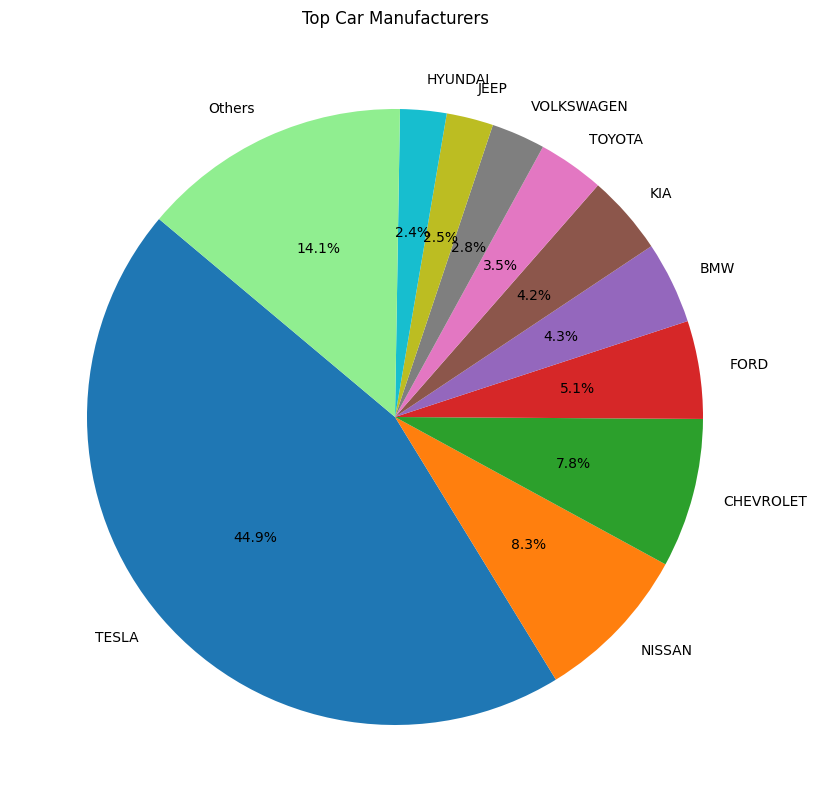

In [32]:
# pie chart of Top Car Manufacturers
car_counts = df['Make'].value_counts()

top_man = car_counts.head(10)

others_count = car_counts[10:].sum()

top_manufacturers = pd.concat([top_man, pd.Series({'Others': others_count})])

custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightgreen']

plt.figure(figsize=(15, 10))
plt.pie(top_manufacturers, labels=top_manufacturers.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top Car Manufacturers')
plt.show()

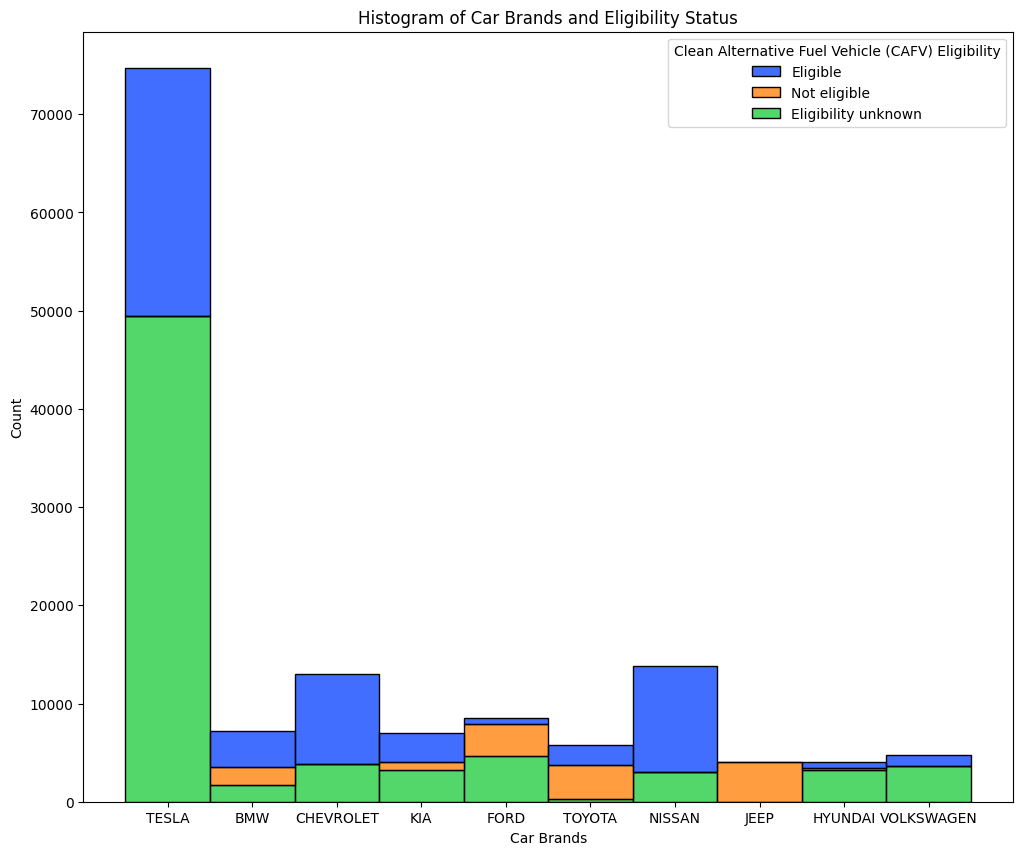

In [33]:
df_filtered = df[df['Make'].isin(top_manufacturers.index)]

plt.figure(figsize=(12, 10))

# stacked histogram
sns.histplot(data=df_filtered, x='Make', hue='Clean Alternative Fuel Vehicle (CAFV) Eligibility', palette='bright', multiple='stack', stat='count')

plt.title('Histogram of Car Brands and Eligibility Status')
plt.xlabel('Car Brands')
plt.ylabel('Count')
plt.show()

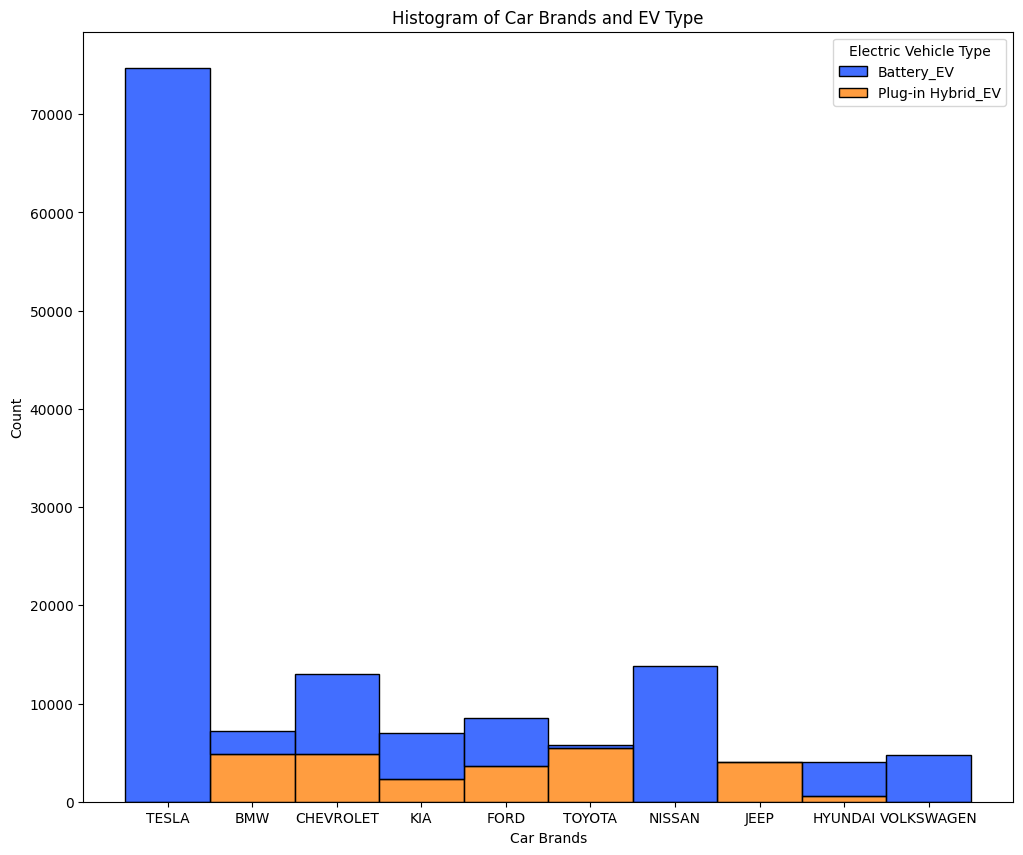

In [34]:
plt.figure(figsize=(12, 10))

# stacked histogram
sns.histplot(data=df_filtered, x='Make', hue='Electric Vehicle Type', palette='bright', multiple='stack', stat='count')


plt.title('Histogram of Car Brands and EV Type')
plt.xlabel('Car Brands')
plt.ylabel('Count')
plt.show()

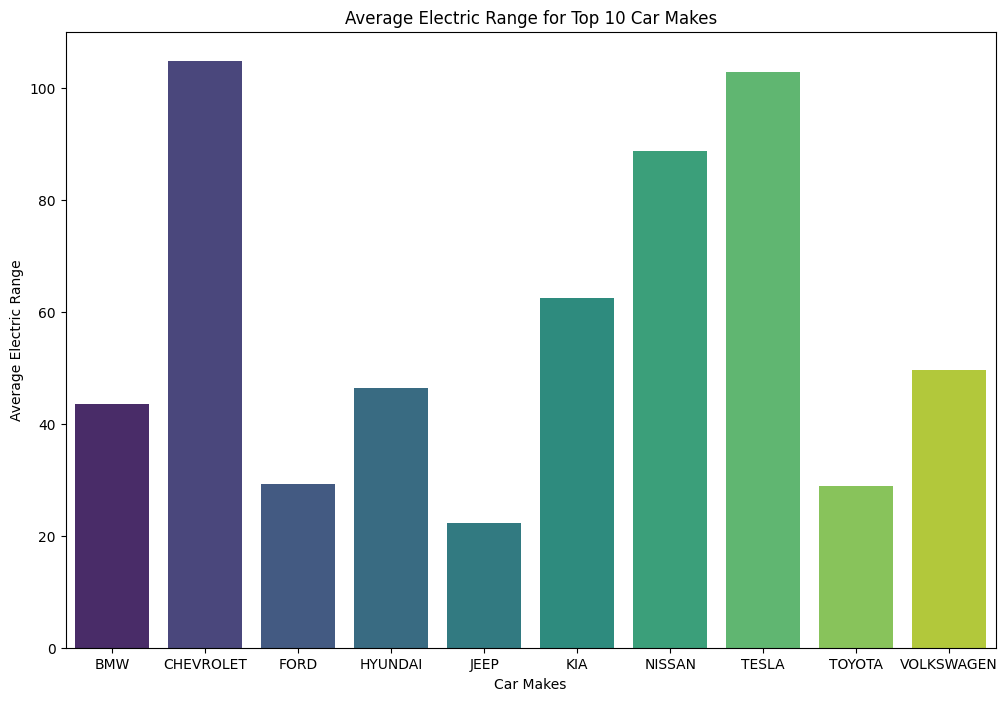

In [35]:
average_range_top_10 = df_filtered.groupby('Make')['Electric Range'].mean()

plt.figure(figsize=(12, 8))
sns.barplot(x=average_range_top_10.index, y=average_range_top_10.values, palette='viridis')
plt.title('Average Electric Range for Top 10 Car Makes')
plt.xlabel('Car Makes')
plt.ylabel('Average Electric Range')
plt.show()


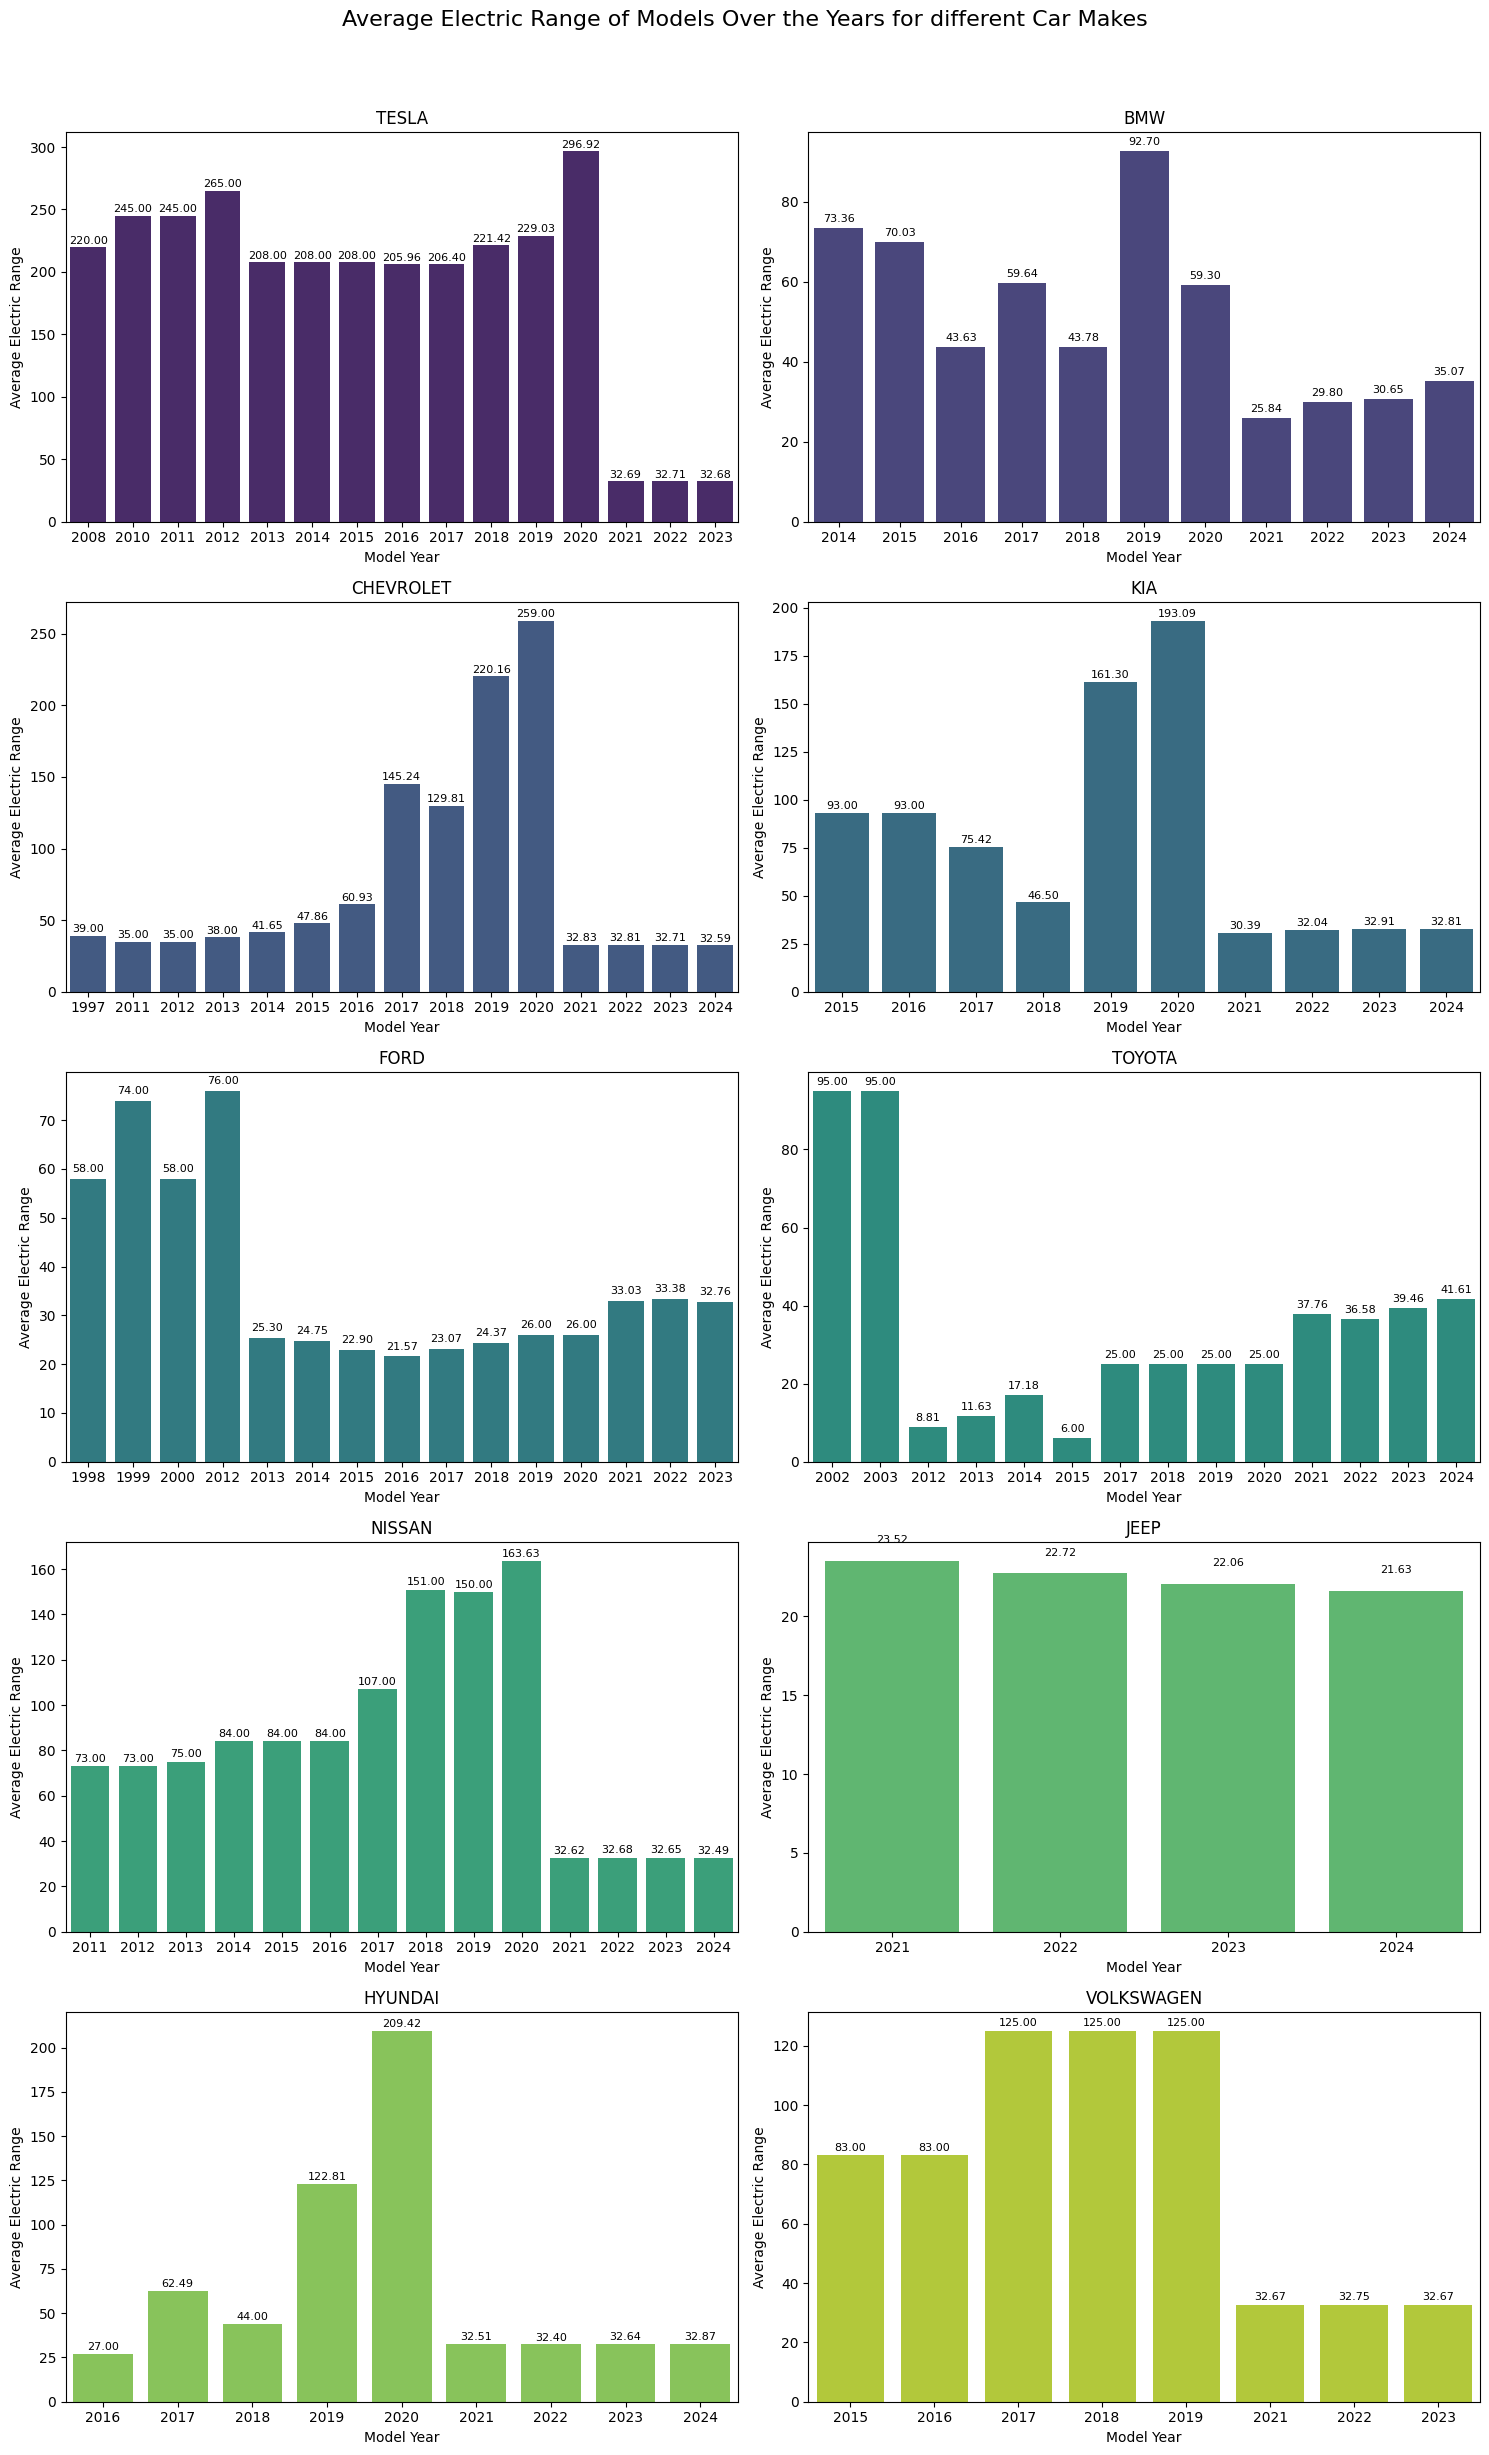

In [36]:
average_range_by_model_year = df_filtered.groupby(['Make', 'Model Year'])['Electric Range'].mean()

unique_makes = df_filtered['Make'].unique()

plots_per_row = 2

num_rows = (len(unique_makes) + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, make in enumerate(unique_makes):
    make_data = average_range_by_model_year.loc[make]
    ax = axes[i]
    
    color = sns.color_palette('viridis', len(unique_makes))[i]    
    sns.barplot(x=make_data.index, y=make_data.values, color=color, ax=ax)
    
    for i, v in enumerate(make_data.values):
        ax.text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='black')
    
    ax.set_title(f'{make}')
    ax.set_xlabel('Model Year')
    ax.set_ylabel('Average Electric Range')

plt.suptitle('Average Electric Range of Models Over the Years for different Car Makes', fontsize=16)

for i in range(len(unique_makes), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.show()